Math 5750/6880: Mathematics of Data Science \
project-2

# 1. Clustering Gaussian Blobs using $k$-means

In [9]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score

from scipy.optimize import linear_sum_assignment  # Hungarian algorithm

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,       # loose
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)



[Result] Smallest KMeans inertia (k=5): 924.3160


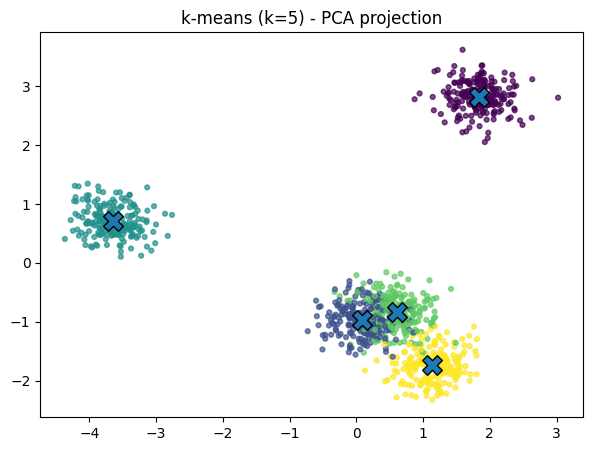

,pred_0,pred_1,pred_2,pred_3,pred_4
true_0,200,0,0,0,0
true_1,0,200,0,0,0
true_2,0,0,200,0,0
true_3,0,0,0,200,0
true_4,0,0,0,0,200


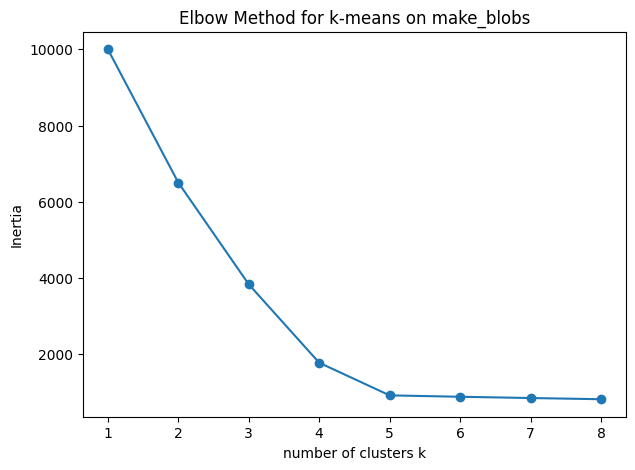

In [10]:
# your code here

# ========== perform a k-means cluster analysis with k = 5 ==========
k = 5
kmeans = KMeans(n_clusters=k, n_init=30, random_state=1)
kmeans.fit(X)

# ========== Report your smallest k-means inertia value ==========
best_inertia = kmeans.inertia_ #record the smallest inertia
print(f"\n[Result] Smallest KMeans inertia (k=5): {best_inertia:.4f}")

# ========== Make a 2D visualization of your clusters via PCA, including both the clusters (colored by cluster) and the cluster centers ==========
labels_pred = kmeans.labels_

pca = PCA(n_components=2, random_state=1)
X2 = pca.fit_transform(X)
centers2 = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7, 5))
plt.scatter(X2[:, 0], X2[:, 1], c=labels_pred, s=12, alpha=0.7)
plt.scatter(centers2[:, 0], centers2[:, 1], marker='X', s=200, edgecolor='k', linewidth=1.0)
plt.title("k-means (k=5) - PCA projection")
plt.show()

# ========== make a confusion matrix that compares your assigned labels to the “true” labels ==========
confusion1 = confusion_matrix(y_true, labels_pred)

row, col = linear_sum_assignment(-confusion1) # to match the pred labels with true labels

pred_to_true = {pred: true for true, pred in zip(row, col)}

labels_remapped = np.vectorize(lambda p: pred_to_true[p])(labels_pred)

confusion1_aligned = confusion_matrix(y_true, labels_remapped)
acc = accuracy_score(y_true, labels_remapped)

df_conf = pd.DataFrame(confusion1_aligned,index=[f"true_{i}" for i in range(k)],columns=[f"pred_{i}" for i in range(k)])
display(df_conf)

# ========== elbow analysis ==========
k_values = list(range(1, 8 + 1))
inertias = []
for k_current in k_values:
    km = KMeans(n_clusters=k_current, n_init=10, random_state=1).fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method for k-means on make_blobs")
plt.xlabel("number of clusters k")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from IPython.display import display
from sklearn.decomposition import PCA

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


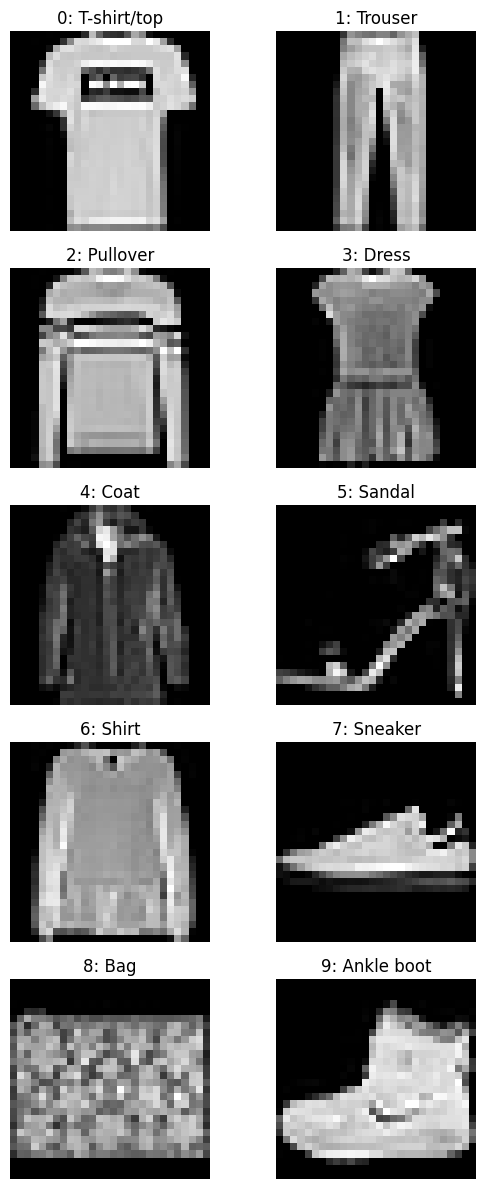


[Result] Smallest KMeans inertia (k=5): 19604098.0000


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0:T-shirt/top,4033,214,57,2,140,575,1947,4,28,0
true_1:Trouser,261,6313,5,0,65,166,189,0,1,0
true_2:Pullover,156,13,33,1,4103,537,2080,4,72,1
true_3:Dress,1866,3722,0,0,50,548,808,0,5,1
true_4:Coat,1063,211,7,0,4136,290,1234,0,59,0
true_5:Sandal,1,2,0,287,0,4592,48,1587,12,471
true_6:Shirt,1293,68,101,3,2191,848,2445,8,41,2
true_7:Sneaker,0,0,0,17,0,643,0,5595,0,745
true_8:Bag,47,20,2476,28,166,445,606,353,2695,164
true_9:Ankle boot,9,4,1,2352,3,197,61,291,0,4082


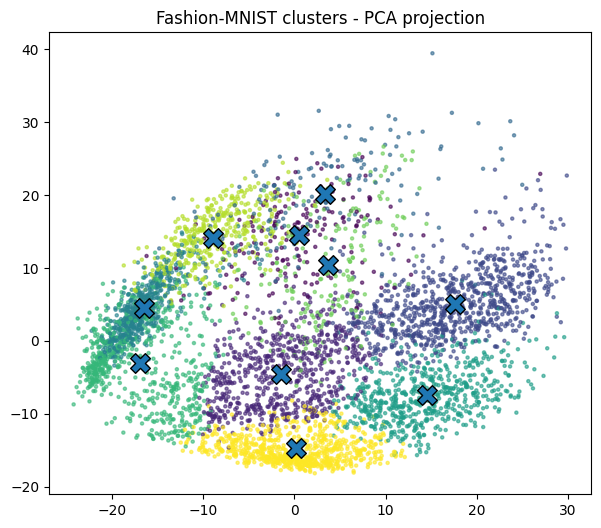

In [6]:
# your code here
CLASS_NAMES = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

# ========== first make a 5×2 array of figures, each plotting a distinct article of clothing ==========

# get all types
samples = [] # set an array
for label in range(10):
    idx = np.where(y == label)[0][0]  # get the first of each type
    samples.append(idx)

# draw the graphs
fig, axes = plt.subplots(5, 2, figsize=(6, 12))
for k, ax in enumerate(axes.ravel()):
    img = X[samples[k]].reshape(28, 28)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{k}: {CLASS_NAMES[k]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# ========== standardlization ==========
X01 = X.astype(np.float32) / 255.0  # scale into [0,1]
scaler = StandardScaler()  # standardlization
X_scaled = scaler.fit_transform(X01).astype(np.float32)

pca = PCA(n_components=50, svd_solver="randomized", random_state=1)
X_pca = pca.fit_transform(X_scaled).astype(np.float32)

# ========== perform a k-means cluster analysis with k = 10 ==========
k = 10
kmeans = KMeans(n_clusters=k,n_init=10,random_state=1)
kmeans.fit(X_pca)

best_inertia = kmeans.inertia_
print(f"\n[Result] Smallest KMeans inertia (k=5): {best_inertia:.4f}")

# ========== make a confusion matrix that compares your assigned labels to the “true” labels ==========
labels_pred = kmeans.labels_

confusion2 = confusion_matrix(y, labels_pred, labels=range(k))

row1, col1 = linear_sum_assignment(-confusion2)

pred_to_true1 = {int(col): int(row) for row, col in zip(row1, col1)}

labels_aligned1 = np.vectorize(lambda p: pred_to_true1[p])(labels_pred)

confusion_aligned1 = confusion_matrix(y, labels_aligned1, labels=range(k))

df_conf = pd.DataFrame(confusion_aligned1,index=[f"true_{i}:{CLASS_NAMES[i]}" for i in range(k)],columns=[f"pred_{i}" for i in range(k)])
display(df_conf)

# ========== Make a 2D visualization of your clusters via PCA, including both the clusters (colored by cluster) and the cluster centers ==========
     # get labels
centers_pca = kmeans.cluster_centers_

pca1 = PCA(n_components=2, random_state=1)
X1 = pca1.fit_transform(X_scaled).astype(np.float32)

rng = np.random.default_rng(1)
plot_idx = rng.choice(X1.shape[0], size=5000, replace=False)

centers_scaled = pca.inverse_transform(centers_pca).astype(np.float32)
centers1 = pca1.transform(centers_scaled).astype(np.float32)

plt.figure(figsize=(7, 6))
plt.scatter(X1[plot_idx, 0], X1[plot_idx, 1],
            c=labels_pred[plot_idx], s=5, alpha=0.6)
plt.scatter(centers1[:, 0], centers1[:, 1],
            marker='X', s=200, edgecolor='k', linewidth=1.0)
plt.title("Fashion-MNIST clusters - PCA projection")
plt.show()

# 3. Dimensionality reduction for Fashion-MNIST

Standardized X shape: (70000, 784)
Subset shape: (3000, 784)
Number of pairwise distances used: 4498500
k= 10 | corr(PCA)=0.9307 | corr(RandomProj)=0.7873
k= 20 | corr(PCA)=0.9654 | corr(RandomProj)=0.8867
k= 50 | corr(PCA)=0.9874 | corr(RandomProj)=0.9500
k=100 | corr(PCA)=0.9954 | corr(RandomProj)=0.9750
k=200 | corr(PCA)=0.9989 | corr(RandomProj)=0.9891

Correlation table:
     k  corr_PCA  corr_RandomProjection
0   10  0.930684               0.787297
1   20  0.965435               0.886651
2   50  0.987415               0.950000
3  100  0.995448               0.974958
4  200  0.998928               0.989110


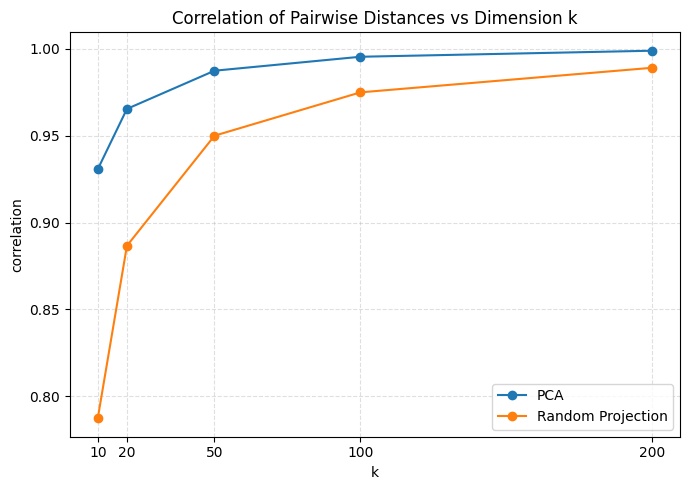

In [12]:
# your code here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import pairwise_distances

np.random.seed(1)

# sample and target dimensiona
N_SUB = 3000    # for faster
KS = [10, 20, 50, 100, 200]

# ========== Import the data and center/scale as appropriate ==========

X01 = X.astype(np.float32) / 255.0  # scale into [0,1]
scaler = StandardScaler()
X_std = scaler.fit_transform(X01).astype(np.float32) # high dimensional data
print("Standardized X shape:", X_std.shape)

idx = np.random.choice(len(X_std), size=N_SUB, replace=False)
X_sub = X_std[idx]
y_sub = y[idx]
print("Subset shape:", X_sub.shape)

# original space
D_orig = pairwise_distances(X_sub, metric="euclidean")
triu_idx = np.triu_indices_from(D_orig, k=1)
d_orig_vec = D_orig[triu_idx]
print("Number of pairwise distances used:", d_orig_vec.shape[0])

# save result
corr_pca = []
corr_rp  = []

# ========== Implement both PCA and Random Projection methods for target dimensions k ∈ {10,20,50,100,200}
# ========== For each reduced dataset, compute the correlation between pairwise distances in the original standardized space and the reduced space.

for k in KS:
    # --- PCA ---
    pca = PCA(n_components=k, svd_solver="randomized")
    X_pca = pca.fit_transform(X_sub)  # (N_sub, k)
    D_pca = pairwise_distances(X_pca, metric="euclidean", n_jobs=-1)
    d_pca_vec = D_pca[triu_idx]
    c_pca = np.corrcoef(d_orig_vec, d_pca_vec)[0, 1]
    corr_pca.append(float(c_pca))

    # --- Gaussian Random Projection ---
    grp = GaussianRandomProjection(n_components=k)
    X_rp = grp.fit_transform(X_sub)   # (N_sub, k)
    D_rp = pairwise_distances(X_rp, metric="euclidean", n_jobs=-1)
    d_rp_vec = D_rp[triu_idx]
    c_rp = np.corrcoef(d_orig_vec, d_rp_vec)[0, 1]
    corr_rp.append(float(c_rp))

    print(f"k={k:3d} | corr(PCA)={c_pca:.4f} | corr(RandomProj)={c_rp:.4f}")

df_corr = pd.DataFrame({
    "k": KS,
    "corr_PCA": corr_pca,
    "corr_RandomProjection": corr_rp
})
print("\nCorrelation table:")
print(df_corr)

# ========== Make a plot of this correlation vs. k for the two methods
plt.figure(figsize=(7, 5))
plt.plot(KS, corr_pca, marker='o', label='PCA')
plt.plot(KS, corr_rp,  marker='o', label='Random Projection')
plt.title("Correlation of Pairwise Distances vs Dimension k")
plt.xlabel("k")
plt.ylabel("correlation")
plt.xticks(KS)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 4. Clustering Fashion-MNIST using spectral clustering


Confusion Matrix:
[[137   0   0  36   6   0  88   0   0   0]
 [  0 271   0  29   4   0  20   0   0   0]
 [  2   0   0   4 199   0  91   0   0   0]
 [  3   0   0 234   2   0  55   0   1   0]
 [  1   0   1  67 232   0  35   0   1   0]
 [  0   0   0   0   0  86   3  90   0 123]
 [ 41   1   4  18 122   0 124   1   0   0]
 [  0   0   0   0   0   5   0 276   0  21]
 [  0   0 108   3  16   0  22  13 121   3]
 [  0   0   0   0   0   0   2  41   0 237]]


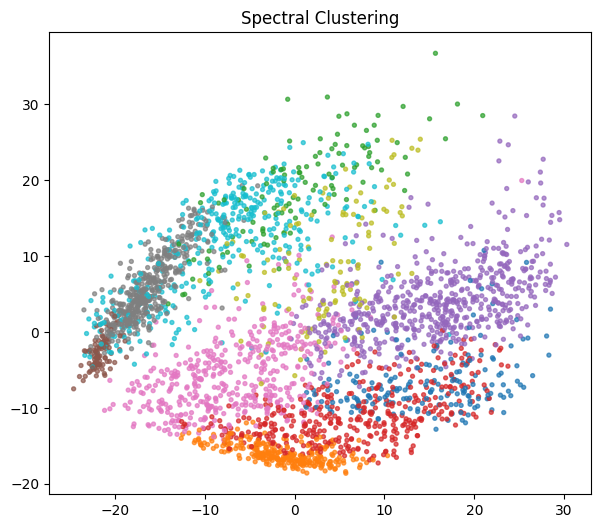


KMeans confusion matrix (after alignment):
[[140  17  70   0   4  32   2   0   2   0]
 [ 11 284  11   0   2  16   0   0   0   0]
 [  8   0 103   1 149  34   0   0   1   0]
 [ 83 153  24   0   1  32   1   0   1   0]
 [ 71   4  62   0 181  17   1   0   1   0]
 [  0   0   0  13   0 185   0  74   2  28]
 [ 45   3  84   1 109  63   3   1   2   0]
 [  0   0   0   1   0  24   0 244   0  33]
 [  1   1  10   7   7  21  98  15 122   4]
 [  1   0   5  76   0   6   0  17   0 175]]


In [17]:
# your code here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

#----------- scale -----------

X01 = (X.astype(np.float32) / 255.0)
scaler = StandardScaler()
X_std = scaler.fit_transform(X01).astype(np.float32)

RNG_SEED = 1
rng = np.random.default_rng(RNG_SEED)

N_SUB = 3000
idx_sub = rng.choice(X_std.shape[0], size=min(N_SUB, X_std.shape[0]), replace=False)

X_sub = X_std[idx_sub]
y_sub = y[idx_sub]

pca50 = PCA(n_components=50, svd_solver="randomized", random_state=RNG_SEED)
X50 = pca50.fit_transform(X_sub).astype(np.float32)

# ========== use spectral clustering to cluster the data
k = 10

spec = SpectralClustering(
    n_clusters=k,
    eigen_solver="arpack",
    affinity="nearest_neighbors",
    n_neighbors=12,
    assign_labels="kmeans",
    random_state=RNG_SEED
)

labels_spec = spec.fit_predict(X50)

C = confusion_matrix(y_sub, labels_spec, labels=range(k))
row_ind, col_ind = linear_sum_assignment(-C)
pred2true = {pred: true for true, pred in zip(row_ind, col_ind)}
y_aligned = np.vectorize(lambda p: pred2true.get(p, -1))(labels_spec)

C_aligned = confusion_matrix(y_sub, y_aligned, labels=range(k))
print("\nConfusion Matrix:")
print(C_aligned)

#---------- visualization ----------
pca2 = PCA(n_components=2, random_state=RNG_SEED)
X2 = pca2.fit_transform(X50)

plt.figure(figsize=(7,6))
plt.scatter(X2[:,0], X2[:,1], c=y_aligned, s=8, alpha=0.7, cmap='tab10')
plt.title("Spectral Clustering")
plt.show()

km = KMeans(n_clusters=k, n_init=10, random_state=RNG_SEED)
labels_km = km.fit_predict(X50)

C_km = confusion_matrix(y_sub, labels_km, labels=range(k))
row_ind, col_ind = linear_sum_assignment(-C_km)
pred2true_km = {pred: true for true, pred in zip(row_ind, col_ind)}
y_km_aligned = np.vectorize(lambda p: pred2true_km.get(p, -1))(labels_km)

C_km_aligned = confusion_matrix(y_sub, y_km_aligned, labels=range(k))
print("\nKMeans confusion matrix (after alignment):")
print(C_km_aligned)